In [85]:
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import IPython.display as ipd
import scipy as sp

In [2]:
def wav_to_tf(filename):
    bits = tf.io.read_file(filename)
    x = tfio.audio.decode_wav(bits,dtype=tf.int16)[:,0]
    x = tf.cast(x,tf.float32)
    x = x - tf.math.reduce_mean(x);
    x = x / tf.math.reduce_std(x)
    return tf.Variable(x)

def play(x):
    ipd.display(ipd.Audio(x,rate=24000,autoplay=False))
    
def slog(x):
    return tf.sign(x) * tf.math.log(1+ tf.math.abs(x) )

def show(X):
    plt.figure(figsize=(30,9),dpi=100)
    plt.imshow(tf.transpose(slog(X)),origin='lower',cmap='PiYG')
    plt.colorbar()
    plt.clim((-8,8))
    
def mdct(x):
    X = tf.signal.mdct(x,624);
    return tf.Variable(X)

def imdct(X):
    y = tf.signal.inverse_mdct(X)
    return y

2023-04-24 11:22:51.880179: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-04-24 11:22:51.880209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 7214
2023-04-24 11:22:51.880214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 7214
2023-04-24 11:22:51.880284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.41.3
2023-04-24 11:22:51.880303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-04-24 11:22:51.880308: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 530.30.2 does not match DSO version 530.41.3 -- cannot find working devices in this configuration
2023-04-24 11:22:51.901625

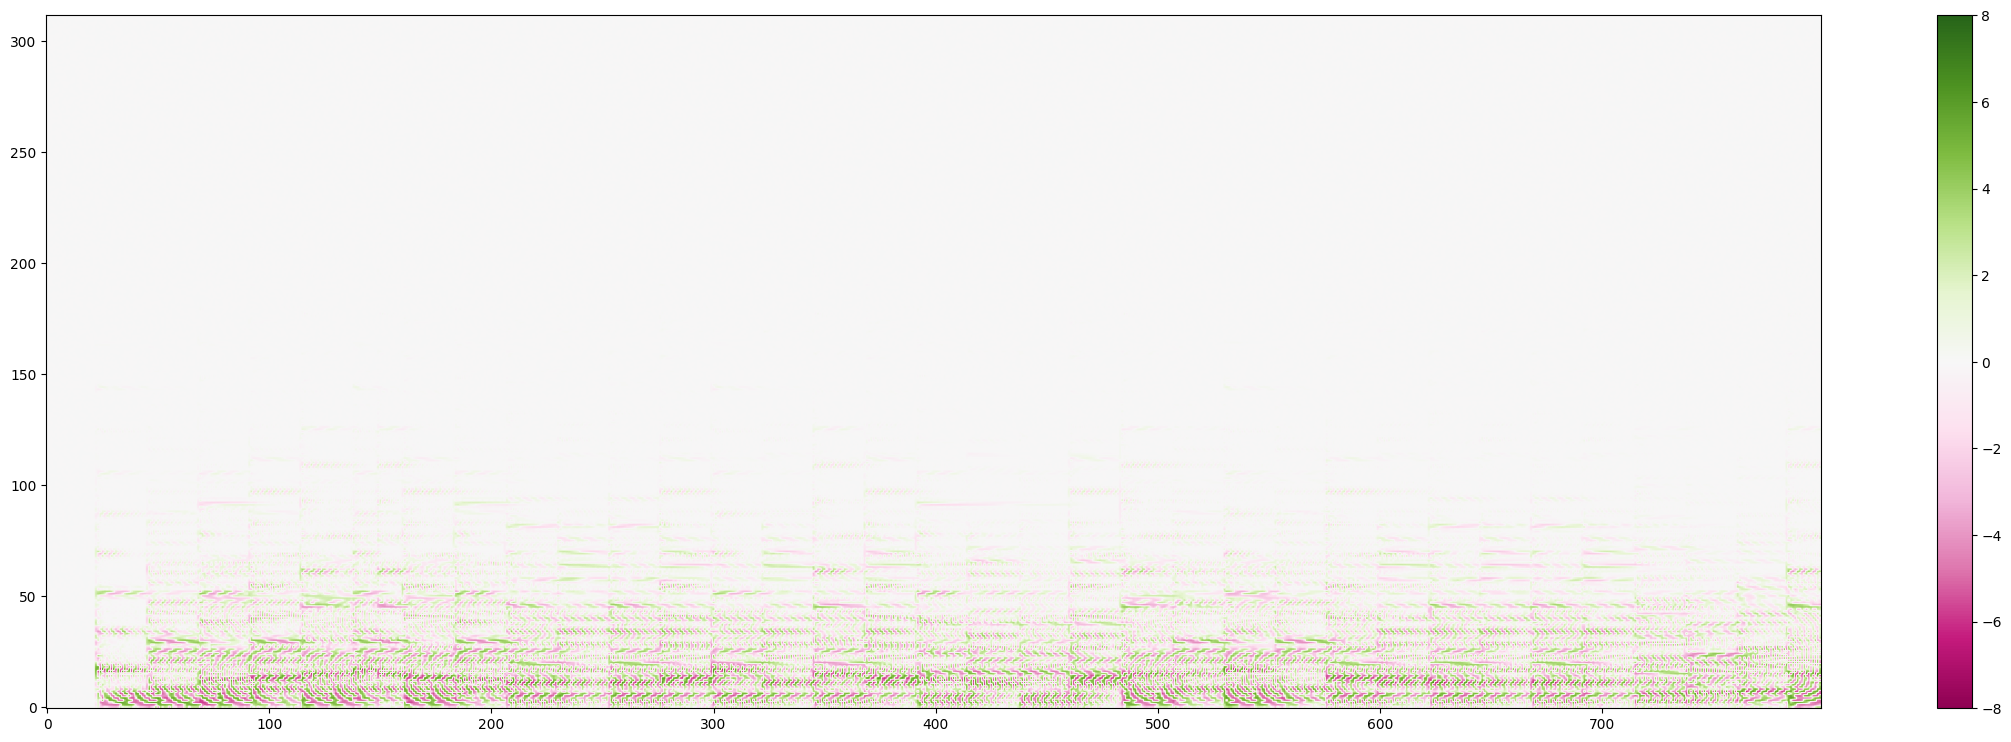

In [3]:
x = wav_to_tf('piano.wav')
X = mdct(x)
y = imdct(X)
play(x)
play(y)
show(X)

Sharifi et al "Estimation of Shape Parameter for Generalized Gaussian Distributions in Subband Decompositions of Video"

Exact relation between variance, mean of the absolute values, and shape parameter:

$$r(\gamma) = \frac{\sigma_X^2}{E^2[|X|]} = \frac{\Gamma(1/\gamma)\Gamma(3/\gamma)
}{\Gamma(2/\gamma)}$$

Procedure to fit GGD parameters:

1. Compute the sample mean $\hat{\mu}_X$
2. Compute the sample standard deviation $\hat{\sigma}_X$
3. Estimate the modified mean of the absolute values $\hat{E}[|X|] = \frac{1}{M} \sum_{i=1}^{M} \left| x_i - \hat{\mu}_X \right|$
4. Estimate the shape parameter $\hat{\gamma}=r^{-1}\left(\frac{\hat{\sigma}^2_X }{\hat{E}^2[|X|}\right)$

In [49]:
Γ = sp.special.gamma

def F(x,μ,σ,γ):
    return sp.stats.gennorm.cdf(x, beta=γ, loc=μ, scale=σ)

def r(γ):
    return Γ(1/γ)*Γ(3/γ)/Γ(2/γ)

def estimate_GGD(X):
    μ = tf.math.reduce_mean(X)
    σ = tf.math.reduce_std(X)
    E = tf.math.reduce_mean(tf.abs(X - μ))
    ρ = tf.square(σ/E)
    
    print('rho',ρ)
    
    
    γ = sp.optimize.bisect(lambda γ:r(γ)-ρ, 0.2, 1.508)
    
    return μ,σ,γ

rho tf.Tensor(1.967344, shape=(), dtype=float32)
rho tf.Tensor(2.5818126, shape=(), dtype=float32)
rho tf.Tensor(1.8426617, shape=(), dtype=float32)


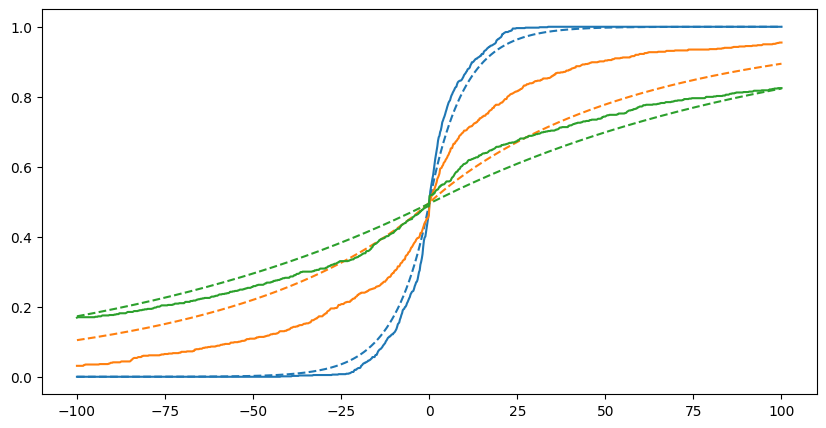

In [116]:
plt.figure(figsize=(10,5),dpi=100)
for i_band in range(3):
    X_band = tf.reshape(X[:,i_band],[-1])
    μ,σ,γ = estimate_GGD(X_band)
    z = tf.cast(tf.linspace(-100,100,1000),tf.float32)
    plt.plot(z,F(z,μ,σ,γ),'--',color='C'+str(i_band))
    d = tfp.distributions.Empirical(X_band)
    plt.plot(z,d.cdf(z),'-', color='C'+str(i_band))